Here is the readme for this dataset: http://sentinel-1-global-coherence-earthbigdata.s3-website-us-west-2.amazonaws.com/#Global_Tiles

There are also information about the dataset here: https://aws.amazon.com/marketplace/pp/prodview-iz6lnjbdlgcwa#usage including sample notebooks

In [24]:
import boto3
import geopandas as gpd
from rasterio.crs import CRS
from shapely.geometry import box
import rasterio
from tqdm import tqdm
import concurrent.futures
import json
import matplotlib.pyplot as plt
from rasterio.plot import show
from shapely.geometry import Polygon
from tile_stitcher.tile_model import TILE_SCHEMA
from tile_stitcher.stitcher import DATA_DIR
from dem_stitcher.geojson_io import to_geojson_gzip

# Read bucket

In [3]:
s3 = boto3.resource('s3')
s1_coh_bucket = s3.Bucket('sentinel-1-global-coherence-earthbigdata')

In [4]:
objects_all = s1_coh_bucket.objects

In [5]:
%%time

tif_tiles = s1_coh_bucket.objects.filter(Prefix='data/tiles/N').all()

CPU times: user 59 µs, sys: 5 µs, total: 64 µs
Wall time: 68.7 µs


In [6]:
%%time

coh_objs = [obj for obj in tif_tiles 
            if (obj.key[-9:-6] == 'COH') and (obj.key[-4:] == '.tif')]
len(coh_objs)

In [26]:
coh_data = [{'bucket': obj.bucket_name, 
                 'key': obj.key} 
             for obj in coh_objs]

In [27]:
json.dump(coh_data, open('coh_s3_data.json', 'w'))

# Load and Inspect

In [7]:
coh_s3_data = json.load(open('coh_s3_data.json'))

In [8]:
data = coh_s3_data[10_000]
bucket = data['bucket']
key = data['key']
with rasterio.open(f's3://{bucket}/{key}') as ds:
    X = ds.read(1)
    p = ds.profile
data, p

({'bucket': 'sentinel-1-global-coherence-earthbigdata',
  'key': 'data/tiles/N04W059/N04W059_summer_vv_COH24.tif'},
 {'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 0.0, 'width': 1200, 'height': 1200, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.00083333333, 0.0, -59.0,
        0.0, -0.00083333333, 4.0), 'blockysize': 6, 'tiled': False, 'compress': 'lzw', 'interleave': 'band'})

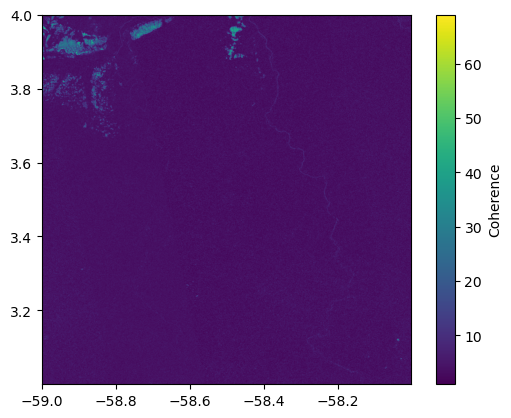

In [9]:
fig, ax=plt.subplots()
out = show(X, transform=p['transform'], ax=ax)
im = out.get_images()[0]

fig.colorbar(im, label='Coherence')

# Create GeoJSON

In [17]:
def get_bounds_from_tile_id(tile_id: str) -> tuple[float]:
    lat_str = tile_id[:3]
    lon_str = tile_id[3:]
    lat = float(tile_id[1:3])
    lon = float(tile_id[4:])
    if 'S' in lat_str:
        lat = -lat
    if 'W' in lon_str:
        lon = -lon
    return lon, lat - 1, lon + 1, lat
    
def get_geometry_from_s3_data(data: dict) -> Polygon:
    key = data['key']
    tile_id = key.split('/')[-1].split('_')[0]
    if len(tile_id) != 7:
        raise ValueError('Malformed Tile ID')
    bounds = get_bounds_from_tile_id(tile_id)        
    return box(*bounds)


def build_url_and_update(data: dict) -> dict:
    bucket = data['bucket']
    key = data['key']
    url = f'https://{bucket}.s3.us-west-2.amazonaws.com/{key}'
    data['url'] = url
    return data

def get_season_and_update(data: dict) -> dict:
    key = data['key']
    fn = key.split('/')[-1]
    tokens = fn.split('_')
    season = tokens[1]
    data['season'] = season
    return data

def get_temporal_baseline_and_update(data: dict) -> dict:
    temporal_baseline = data['key'][-6:-4]
    data['temporal_baseline_days'] = int(temporal_baseline)
    return data

def get_tile_id_and_update(data: dict) -> dict:
    key = data['key']
    tile_id = key.split('/')[-1].split('_')[0]
    data['tile_id'] = tile_id
    return data

In [18]:
out_data = list(map(build_url_and_update, coh_s3_data))
out_data = list(map(get_temporal_baseline_and_update, out_data))
out_data = list(map(get_season_and_update, out_data))
out_data = list(map(get_tile_id_and_update, out_data))

out_data[0]

{'bucket': 'sentinel-1-global-coherence-earthbigdata',
 'key': 'data/tiles/N00E005/N00E005_fall_vv_COH12.tif',
 'url': 'https://sentinel-1-global-coherence-earthbigdata.s3.us-west-2.amazonaws.com/data/tiles/N00E005/N00E005_fall_vv_COH12.tif',
 'temporal_baseline_days': 12,
 'season': 'fall',
 'tile_id': 'N00E005'}

In [19]:
geometry = list(map(get_geometry_from_s3_data, tqdm(coh_s3_data)))

100%|█████████████████████████████| 314451/314451 [00:03<00:00, 95226.17it/s]


In [20]:
df = gpd.GeoDataFrame(coh_s3_data, geometry=geometry, crs=CRS.from_epsg(4326))
# We remove 
df = df.drop(columns=['key', 'bucket'])
df.head()

,url,temporal_baseline_days,season,tile_id,geometry
0,https://sentinel-1-global-coherence-earthbigda...,12,fall,N00E005,"POLYGON ((6.00000 -1.00000, 6.00000 0.00000, 5..."
1,https://sentinel-1-global-coherence-earthbigda...,24,fall,N00E005,"POLYGON ((6.00000 -1.00000, 6.00000 0.00000, 5..."
2,https://sentinel-1-global-coherence-earthbigda...,36,fall,N00E005,"POLYGON ((6.00000 -1.00000, 6.00000 0.00000, 5..."
3,https://sentinel-1-global-coherence-earthbigda...,48,fall,N00E005,"POLYGON ((6.00000 -1.00000, 6.00000 0.00000, 5..."
4,https://sentinel-1-global-coherence-earthbigda...,12,spring,N00E005,"POLYGON ((6.00000 -1.00000, 6.00000 0.00000, 5..."


<Axes: >

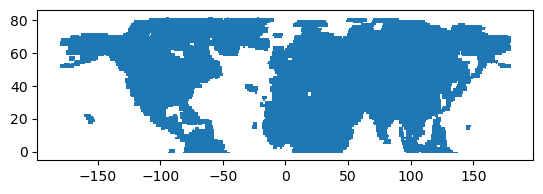

In [21]:
df.plot()

In [22]:
df_group = df.groupby('tile_id').count()
df_group

,url,temporal_baseline_days,season,geometry
tile_id,,,,
N00E005,16,16,16,16
N00E006,16,16,16,16
N00E007,16,16,16,16
N00E008,16,16,16,16
N00E009,16,16,16,16
...,...,...,...,...
N82W060,24,24,24,24
N82W061,24,24,24,24
N82W062,24,24,24,24


In [23]:
df = TILE_SCHEMA.validate(df)

In [26]:
df.temporal_baseline_days.unique()

array([12, 24, 36, 48,  6, 18])

# Serialize

In [25]:
to_geojson_gzip(df, str(DATA_DIR / 's1_coherence_2020.geojson.zip'))

'/Users/cmarshak/bekaert-team/tile-stitcher/tile_stitcher/data/s1_coherence_2020.geojson.zip'

In [29]:
_TEMPORAL_BASELINE_DAYS = list(range(6, 49, 6))
_TEMPORAL_BASELINE_DAYS

[6, 12, 18, 24, 30, 36, 42, 48]

In [28]:
_TEMPORAL_BASELINE_DAYS

range(6, 49, 6)